In [1]:
from plot import tier1_plot
from geogiant.common.settings import PathSettings, ClickhouseSettings

path_settings = PathSettings()
clickhouse_settings = ClickhouseSettings()

# AMAZON / AWSDNS eval

2024-05-02 17:04:28.253 | INFO     | plot:tier1_plot:417 - file='results__1_hostname_AMAZON_ns_awsdns.pickle'


2024-05-02 17:04:28.868 | INFO     | plot:tier1_plot:423 - Answer subnet granularity::
2024-05-02 17:04:28.869 | INFO     | plot:plot_per_granularity:326 - len(total_hostnames)=1
2024-05-02 17:04:28.870 | INFO     | plot:plot_per_granularity:327 - nb targets:: 759
2024-05-02 17:04:28.875 | INFO     | plot:plot_per_granularity:365 - ECS SP:: jaccard, median_error=16.57 [km], 1 hostnames
2024-05-02 17:04:28.876 | INFO     | plot:plot_per_granularity:373 - ECS SP:: jaccard, <40km=0.58, 1 hostnames
2024-05-02 17:04:28.876 | INFO     | plot:plot_per_granularity:376 - ECS SP:: jaccard, median_error=16.57 [km], 1 hostnames
2024-05-02 17:04:28.878 | INFO     | plot:tier1_plot:417 - file='results__10_hostname_AMAZON_ns_awsdns.pickle'
2024-05-02 17:04:29.296 | INFO     | plot:tier1_plot:423 - Answer subnet granularity::
2024-05-02 17:04:29.297 | INFO     | plot:plot_per_granularity:326 - len(total_hostnames)=10
2024-05-02 17:04:29.298 | INFO     | plot:plot_per_granularity:327 - nb targets:: 759

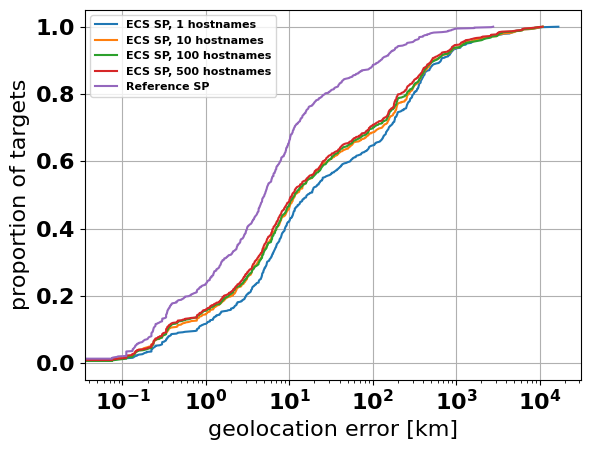

2024-05-02 17:04:31.325 | INFO     | plot:tier1_plot:417 - file='results__1_hostname_AMAZON_ns_awsdns.pickle'
2024-05-02 17:04:31.639 | INFO     | plot:tier1_plot:423 - Answer subnet granularity::
2024-05-02 17:04:31.641 | INFO     | plot:plot_per_granularity:326 - len(total_hostnames)=1
2024-05-02 17:04:31.642 | INFO     | plot:plot_per_granularity:327 - nb targets:: 759
2024-05-02 17:04:31.647 | INFO     | plot:plot_per_granularity:365 - ECS SP:: jaccard, median_error=1.5 [km], 1 hostnames
2024-05-02 17:04:31.648 | INFO     | plot:plot_per_granularity:373 - ECS SP:: jaccard, <40km=0.96, 1 hostnames
2024-05-02 17:04:31.649 | INFO     | plot:plot_per_granularity:376 - ECS SP:: jaccard, median_error=1.5 [km], 1 hostnames
2024-05-02 17:04:31.651 | INFO     | plot:tier1_plot:417 - file='results__10_hostname_AMAZON_ns_awsdns.pickle'
2024-05-02 17:04:32.014 | INFO     | plot:tier1_plot:423 - Answer subnet granularity::
2024-05-02 17:04:32.016 | INFO     | plot:plot_per_granularity:326 - len

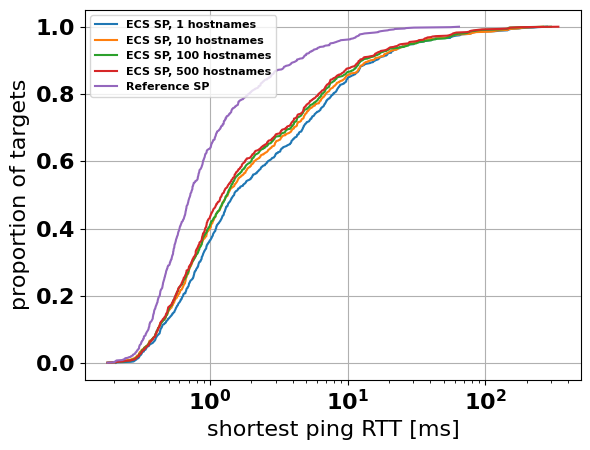

In [2]:
tier1_plot(
    eval_dir=path_settings.RESULTS_PATH / "tier1_evaluation/",
    granularities=["answer_subnets"],
    probing_budgets_evaluated=[50],
    metric_evaluated="d_error",
    filter_org=["AMAZON"],
)

tier1_plot(
    eval_dir=path_settings.RESULTS_PATH / "tier1_evaluation/",
    granularities=["answer_subnets"],
    probing_budgets_evaluated=[50],
    metric_evaluated="rtt",
    filter_org=["AMAZON"],
)

# GOOGLE analysis

2024-05-02 17:04:33.917 | INFO     | plot:tier1_plot:417 - file='results__1_hostname_GOOGLE_ns_google.pickle'


2024-05-02 17:04:34.608 | INFO     | plot:tier1_plot:423 - Answer subnet granularity::
2024-05-02 17:04:34.610 | INFO     | plot:plot_per_granularity:326 - len(total_hostnames)=1
2024-05-02 17:04:34.611 | INFO     | plot:plot_per_granularity:327 - nb targets:: 759
2024-05-02 17:04:34.614 | INFO     | plot:plot_per_granularity:365 - ECS SP:: jaccard, median_error=149.46 [km], 1 hostnames
2024-05-02 17:04:34.615 | INFO     | plot:plot_per_granularity:373 - ECS SP:: jaccard, <40km=0.39, 1 hostnames
2024-05-02 17:04:34.616 | INFO     | plot:plot_per_granularity:376 - ECS SP:: jaccard, median_error=149.46 [km], 1 hostnames
2024-05-02 17:04:34.618 | INFO     | plot:tier1_plot:417 - file='results__10_hostname_GOOGLE_ns_google.pickle'
2024-05-02 17:04:34.933 | INFO     | plot:tier1_plot:423 - Answer subnet granularity::
2024-05-02 17:04:34.935 | INFO     | plot:plot_per_granularity:326 - len(total_hostnames)=10
2024-05-02 17:04:34.936 | INFO     | plot:plot_per_granularity:327 - nb targets:: 7

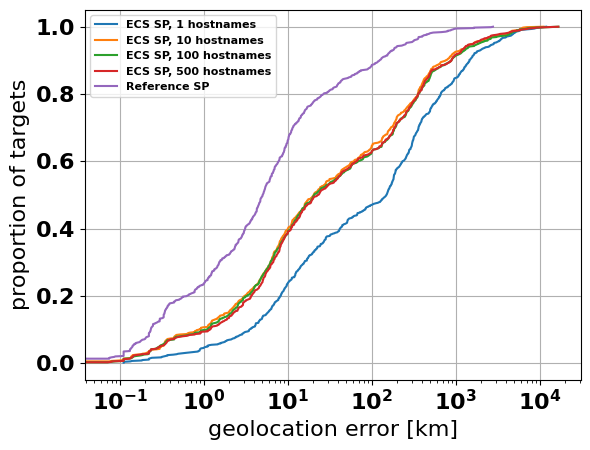

In [3]:
tier1_plot(
    eval_dir=path_settings.RESULTS_PATH / "tier1_evaluation/",
    granularities=["answer_subnets"],
    probing_budgets_evaluated=[50],
    metric_evaluated="d_error",
    filter_org=["GOOGLE"],
)

# AKAMAI evaluation

2024-05-02 17:04:37.177 | INFO     | plot:tier1_plot:417 - file='results__1_hostname_AKAMAI_ns_akamai.pickle'
2024-05-02 17:04:37.192 | INFO     | plot:tier1_plot:423 - Answer subnet granularity::
2024-05-02 17:04:37.194 | INFO     | plot:plot_per_granularity:326 - len(total_hostnames)=1
2024-05-02 17:04:37.197 | INFO     | plot:plot_per_granularity:327 - nb targets:: 759
2024-05-02 17:04:37.199 | INFO     | plot:plot_per_granularity:365 - ECS SP:: jaccard, median_error=58.16 [km], 1 hostnames


2024-05-02 17:04:37.200 | INFO     | plot:plot_per_granularity:373 - ECS SP:: jaccard, <40km=0.48, 1 hostnames
2024-05-02 17:04:37.201 | INFO     | plot:plot_per_granularity:376 - ECS SP:: jaccard, median_error=58.16 [km], 1 hostnames
2024-05-02 17:04:37.204 | INFO     | plot:tier1_plot:417 - file='results__10_hostname_AKAMAI_ns_akamai.pickle'
2024-05-02 17:04:37.820 | INFO     | plot:tier1_plot:423 - Answer subnet granularity::
2024-05-02 17:04:37.822 | INFO     | plot:plot_per_granularity:326 - len(total_hostnames)=10
2024-05-02 17:04:37.824 | INFO     | plot:plot_per_granularity:327 - nb targets:: 759
2024-05-02 17:04:37.828 | INFO     | plot:plot_per_granularity:365 - ECS SP:: jaccard, median_error=30.16 [km], 10 hostnames
2024-05-02 17:04:37.829 | INFO     | plot:plot_per_granularity:373 - ECS SP:: jaccard, <40km=0.53, 10 hostnames
2024-05-02 17:04:37.830 | INFO     | plot:plot_per_granularity:376 - ECS SP:: jaccard, median_error=30.16 [km], 10 hostnames
2024-05-02 17:04:37.832 | 

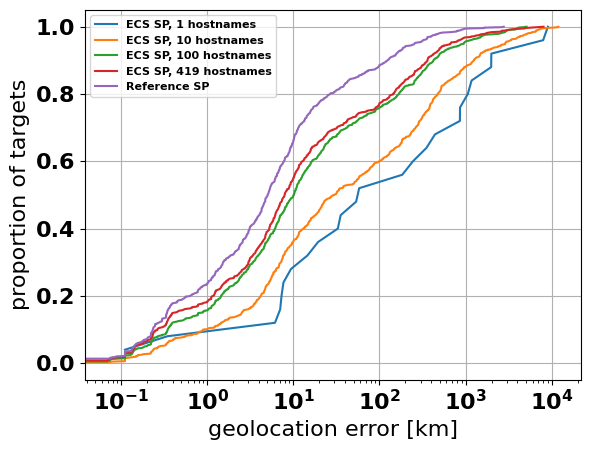

In [4]:
tier1_plot(
    eval_dir=path_settings.RESULTS_PATH / "tier1_evaluation/",
    granularities=["answer_subnets"],
    probing_budgets_evaluated=[50],
    metric_evaluated="d_error",
    filter_org=["AKAMAI"],
)

2024-05-02 17:14:30.386 | INFO     | plot:tier1_plot:417 - file='results__1_hostname_FACEBOOK_ns_facebook.pickle'
2024-05-02 17:14:30.825 | INFO     | plot:tier1_plot:423 - Answer subnet granularity::
2024-05-02 17:14:30.827 | INFO     | plot:plot_per_granularity:326 - len(total_hostnames)=1
2024-05-02 17:14:30.828 | INFO     | plot:plot_per_granularity:327 - nb targets:: 759
2024-05-02 17:14:30.833 | INFO     | plot:plot_per_granularity:365 - ECS SP:: jaccard, median_error=18.31 [km], 1 hostnames
2024-05-02 17:14:30.834 | INFO     | plot:plot_per_granularity:373 - ECS SP:: jaccard, <40km=0.59, 1 hostnames
2024-05-02 17:14:30.835 | INFO     | plot:plot_per_granularity:376 - ECS SP:: jaccard, median_error=18.31 [km], 1 hostnames
2024-05-02 17:14:30.837 | INFO     | plot:tier1_plot:417 - file='results__10_hostname_FACEBOOK_ns_facebook.pickle'
2024-05-02 17:14:31.389 | INFO     | plot:tier1_plot:423 - Answer subnet granularity::
2024-05-02 17:14:31.392 | INFO     | plot:plot_per_granulari

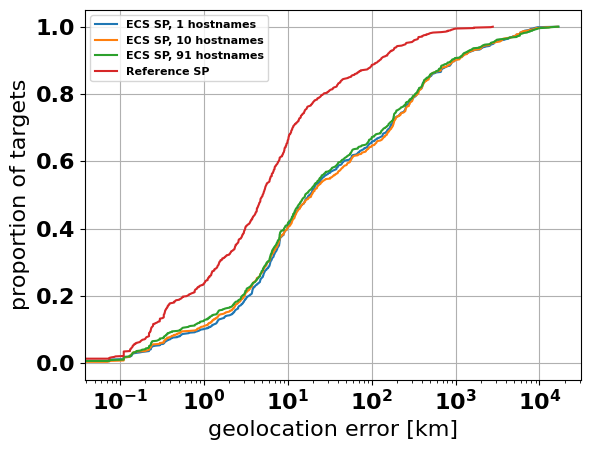

In [8]:
tier1_plot(
    eval_dir=path_settings.RESULTS_PATH / "tier1_evaluation/",
    granularities=["answer_subnets"],
    probing_budgets_evaluated=[50],
    metric_evaluated="d_error",
    filter_org=["FACEBOOK"],
)

# INCAPSULA evaluation

2024-05-02 17:04:39.526 | INFO     | plot:tier1_plot:417 - file='results__1_hostname_INCAPSULA_ns_impervadns.pickle'


2024-05-02 17:04:39.780 | INFO     | plot:tier1_plot:423 - Answer subnet granularity::
2024-05-02 17:04:39.782 | INFO     | plot:plot_per_granularity:326 - len(total_hostnames)=1
2024-05-02 17:04:39.783 | INFO     | plot:plot_per_granularity:327 - nb targets:: 759
2024-05-02 17:04:39.788 | INFO     | plot:plot_per_granularity:365 - ECS SP:: jaccard, median_error=10.68 [km], 1 hostnames
2024-05-02 17:04:39.794 | INFO     | plot:plot_per_granularity:373 - ECS SP:: jaccard, <40km=0.66, 1 hostnames
2024-05-02 17:04:39.796 | INFO     | plot:plot_per_granularity:376 - ECS SP:: jaccard, median_error=10.68 [km], 1 hostnames
2024-05-02 17:04:39.798 | INFO     | plot:tier1_plot:417 - file='results__10_hostname_INCAPSULA_ns_impervadns.pickle'
2024-05-02 17:04:40.361 | INFO     | plot:tier1_plot:423 - Answer subnet granularity::
2024-05-02 17:04:40.364 | INFO     | plot:plot_per_granularity:326 - len(total_hostnames)=10
2024-05-02 17:04:40.366 | INFO     | plot:plot_per_granularity:327 - nb target

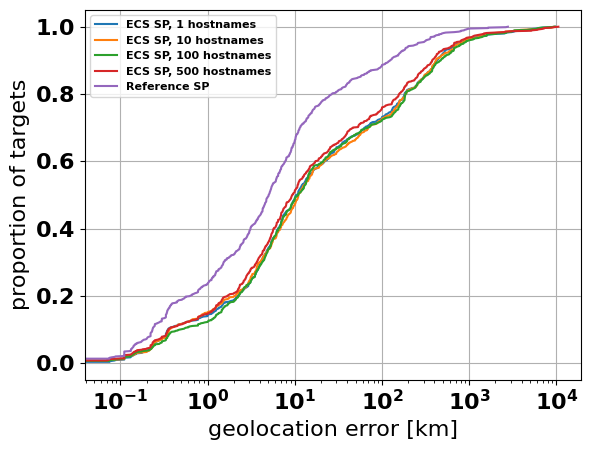

In [5]:
tier1_plot(
    eval_dir=path_settings.RESULTS_PATH / "tier1_evaluation/",
    granularities=["answer_subnets"],
    probing_budgets_evaluated=[50],
    metric_evaluated="d_error",
    filter_org=["INCAPSULA"],
)

# AS-HOSTINGER evaluation

2024-05-02 17:04:41.809 | INFO     | plot:tier1_plot:417 - file='results__1_hostname_AS-HOSTINGER_ns_dns-parking.pickle'
2024-05-02 17:04:41.817 | INFO     | plot:tier1_plot:423 - Answer subnet granularity::
2024-05-02 17:04:41.821 | INFO     | plot:plot_per_granularity:326 - len(total_hostnames)=1
2024-05-02 17:04:41.823 | INFO     | plot:plot_per_granularity:327 - nb targets:: 759
2024-05-02 17:04:41.825 | INFO     | plot:plot_per_granularity:365 - ECS SP:: jaccard, median_error=360.76 [km], 1 hostnames
2024-05-02 17:04:41.827 | INFO     | plot:plot_per_granularity:373 - ECS SP:: jaccard, <40km=0.27, 1 hostnames
2024-05-02 17:04:41.828 | INFO     | plot:plot_per_granularity:376 - ECS SP:: jaccard, median_error=360.76 [km], 1 hostnames
2024-05-02 17:04:41.831 | INFO     | plot:tier1_plot:417 - file='results__10_hostname_AS-HOSTINGER_ns_dns-parking.pickle'
2024-05-02 17:04:41.877 | INFO     | plot:tier1_plot:423 - Answer subnet granularity::
2024-05-02 17:04:41.879 | INFO     | plot:pl

2024-05-02 17:04:42.328 | INFO     | plot:tier1_plot:423 - Answer subnet granularity::
2024-05-02 17:04:42.332 | INFO     | plot:plot_per_granularity:326 - len(total_hostnames)=100
2024-05-02 17:04:42.334 | INFO     | plot:plot_per_granularity:327 - nb targets:: 759
2024-05-02 17:04:42.345 | INFO     | plot:plot_per_granularity:365 - ECS SP:: jaccard, median_error=185.17 [km], 100 hostnames
2024-05-02 17:04:42.346 | INFO     | plot:plot_per_granularity:373 - ECS SP:: jaccard, <40km=0.32, 100 hostnames
2024-05-02 17:04:42.347 | INFO     | plot:plot_per_granularity:376 - ECS SP:: jaccard, median_error=185.17 [km], 100 hostnames
2024-05-02 17:04:42.349 | INFO     | plot:tier1_plot:417 - file='results__237_hostname_AS-HOSTINGER_ns_dns-parking.pickle'
2024-05-02 17:04:43.382 | INFO     | plot:tier1_plot:423 - Answer subnet granularity::
2024-05-02 17:04:43.385 | INFO     | plot:plot_per_granularity:326 - len(total_hostnames)=237
2024-05-02 17:04:43.387 | INFO     | plot:plot_per_granularity

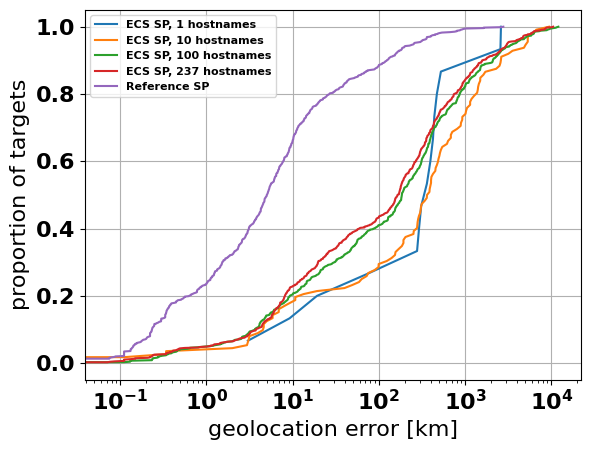

In [6]:
tier1_plot(
    eval_dir=path_settings.RESULTS_PATH / "tier1_evaluation/",
    granularities=["answer_subnets"],
    probing_budgets_evaluated=[50],
    metric_evaluated="d_error",
    filter_org=["AS-HOSTINGER"],
)

# CDN77 evaluation

2024-05-02 17:04:44.496 | INFO     | plot:tier1_plot:417 - file='results__1_hostname_CDN77_ns_bunny.pickle'


2024-05-02 17:04:44.949 | INFO     | plot:tier1_plot:423 - Answer subnet granularity::
2024-05-02 17:04:44.951 | INFO     | plot:plot_per_granularity:326 - len(total_hostnames)=1
2024-05-02 17:04:44.952 | INFO     | plot:plot_per_granularity:327 - nb targets:: 759
2024-05-02 17:04:44.957 | INFO     | plot:plot_per_granularity:365 - ECS SP:: jaccard, median_error=10.44 [km], 1 hostnames
2024-05-02 17:04:44.958 | INFO     | plot:plot_per_granularity:373 - ECS SP:: jaccard, <40km=0.68, 1 hostnames
2024-05-02 17:04:44.959 | INFO     | plot:plot_per_granularity:376 - ECS SP:: jaccard, median_error=10.44 [km], 1 hostnames
2024-05-02 17:04:44.961 | INFO     | plot:tier1_plot:417 - file='results__10_hostname_CDN77_ns_bunny.pickle'
2024-05-02 17:04:45.380 | INFO     | plot:tier1_plot:423 - Answer subnet granularity::
2024-05-02 17:04:45.382 | INFO     | plot:plot_per_granularity:326 - len(total_hostnames)=10
2024-05-02 17:04:45.383 | INFO     | plot:plot_per_granularity:327 - nb targets:: 759
2

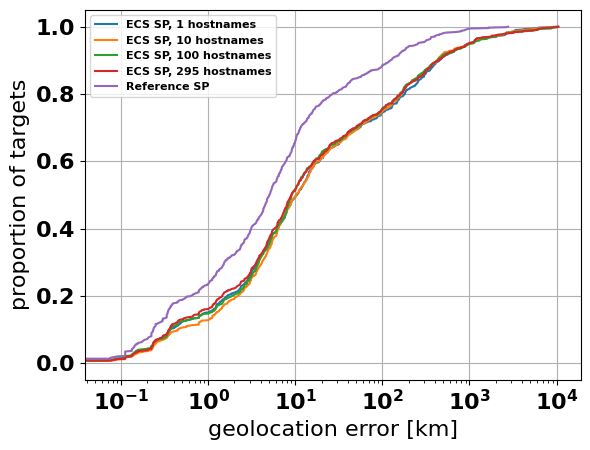

In [7]:
tier1_plot(
    eval_dir=path_settings.RESULTS_PATH / "tier1_evaluation/",
    granularities=["answer_subnets"],
    probing_budgets_evaluated=[50],
    metric_evaluated="d_error",
    filter_org=["CDN77"],
)